In [1]:
import sklearn
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
# import albumentations as A

print(sklearn.__version__)

1.3.2


In [2]:
def get_video_metadata(filepath, exercise_name, execise_type):
    cap = cv2.VideoCapture(filepath)

    if not cap.isOpened():
        print(f"Error: Could not open video {filepath}.")
        return None

    # Get video properties
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    cap.release()

    res = {
        "Full path": filepath,
        "Filename": exercise_name,
        "Exercise": execise_type,
        "Duration (seconds)": duration,
        "Width": width,
        "Height": height,
        "FPS": fps,
        "Frame Count": frame_count
        }

    return res

In [3]:
def create_video_dataframe(video_folder):

    # List to hold video metadata
    video_data = []
    extensions = ['.mp4', '.mov']

    # Iterate over each video in the folder
    for root, dirs, files in os.walk(video_folder):
        for filename in files:
            if any(filename.endswith(ext) for ext in extensions):
                filepath = os.path.join(root, filename)
                exercise = os.path.basename(root)
                metadata = get_video_metadata(filepath, filename, exercise)
                if metadata:
                    video_data.append(metadata)

    return pd.DataFrame(video_data)



video_folder = "data/raw_data/"
meta_data = create_video_dataframe(video_folder)
meta_data.to_csv(os.path.join(video_folder, "metadata.csv"))
print(meta_data[:5])


                                           Full path  \
0  data/raw_data/barbell biceps curl\barbell bice...   
1  data/raw_data/barbell biceps curl\barbell bice...   
2  data/raw_data/barbell biceps curl\barbell bice...   
3  data/raw_data/barbell biceps curl\barbell bice...   
4  data/raw_data/barbell biceps curl\barbell bice...   

                     Filename             Exercise  Duration (seconds)  \
0   barbell biceps curl_1.mp4  barbell biceps curl            3.803800   
1  barbell biceps curl_10.mp4  barbell biceps curl            3.136467   
2  barbell biceps curl_11.mp4  barbell biceps curl            2.502500   
3  barbell biceps curl_12.mp4  barbell biceps curl            4.104100   
4  barbell biceps curl_13.mp4  barbell biceps curl            4.070733   

    Width  Height       FPS  Frame Count  
0  1920.0  1080.0  29.97003          114  
1  1920.0  1080.0  29.97003           94  
2  1920.0  1080.0  29.97003           75  
3  1920.0  1080.0  29.97003          123  
4  

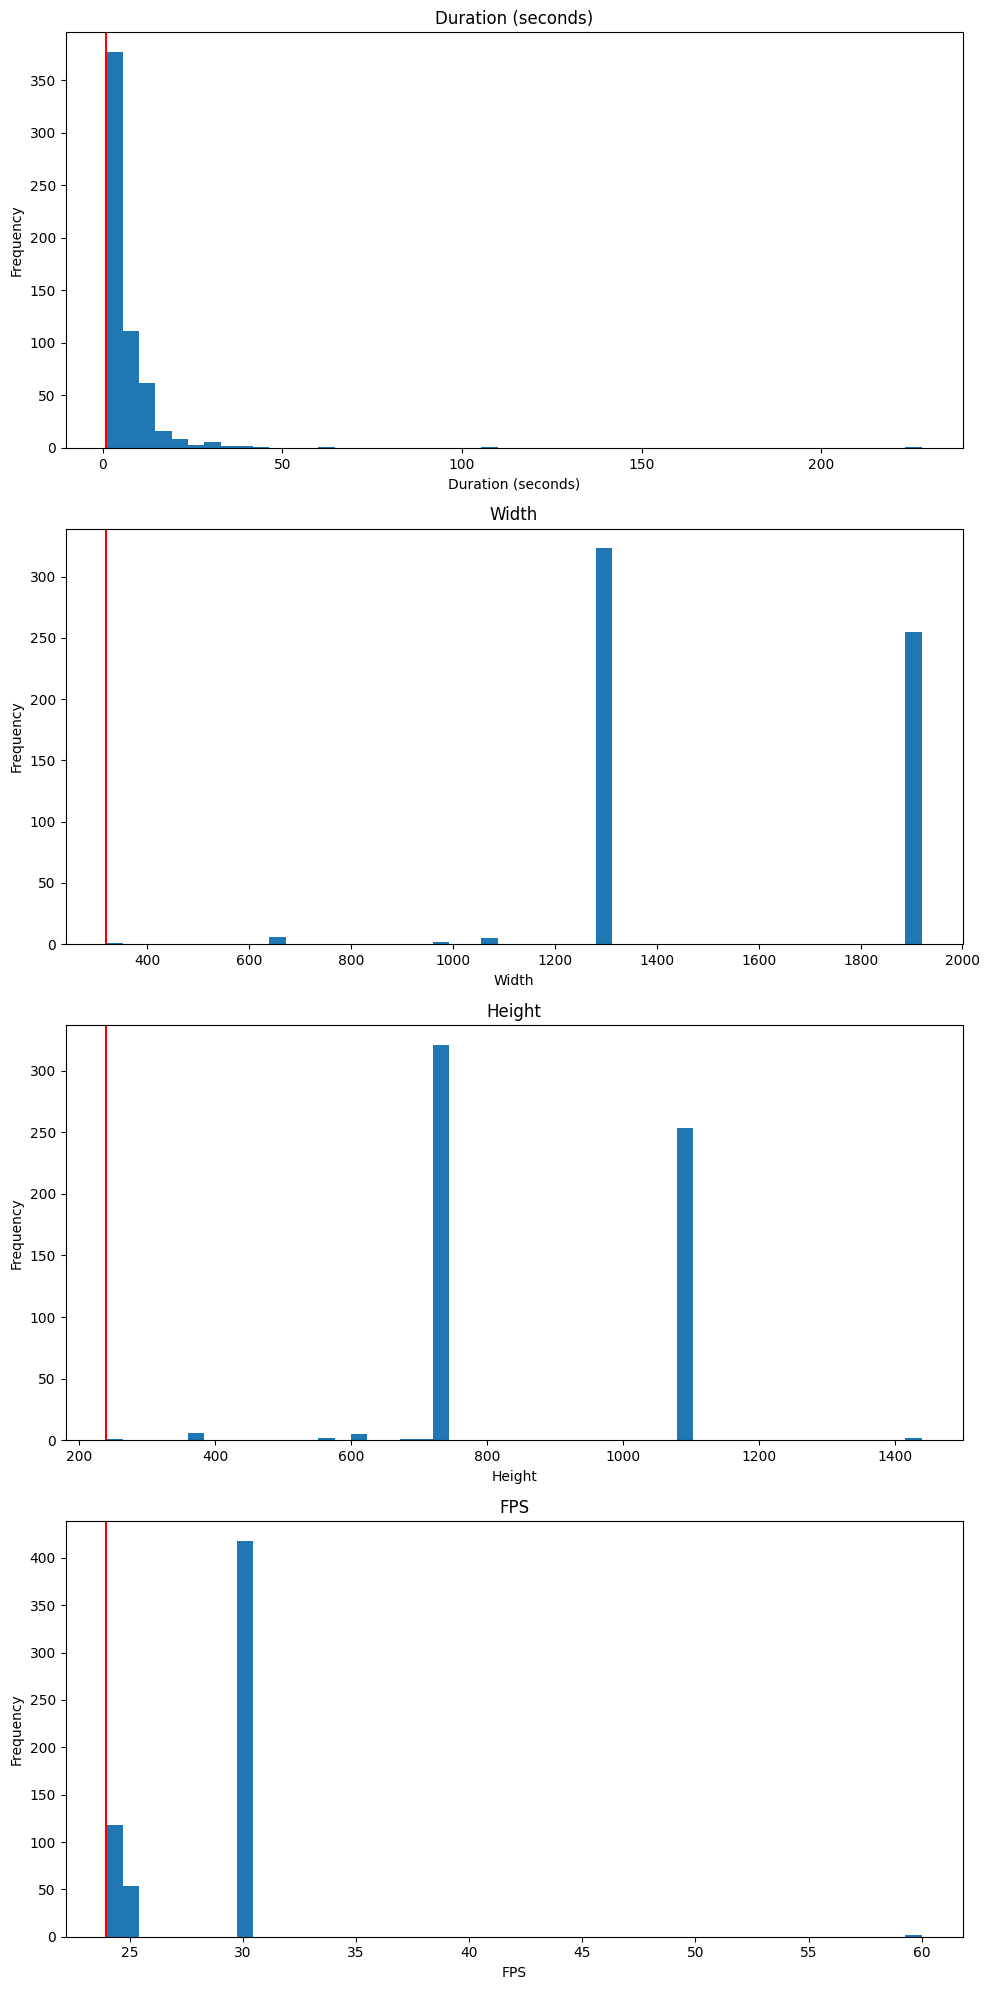

The initial summarry of the data is:


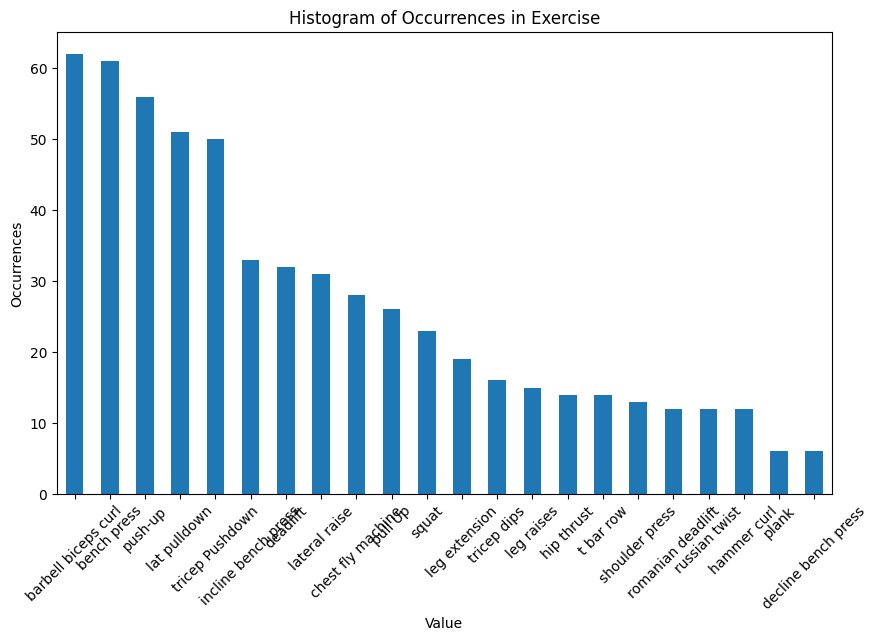

In [4]:
# Filter out the columns that are not in the DataFrame
columns = ["Duration (seconds)", "Width", "Height", "FPS"]

# Number of valid columns
num_columns = len(columns)

# Set up the matplotlib figure
fig, axs = plt.subplots(num_columns, figsize=(10, 5 * num_columns), sharex=False)

# Iterate over each valid column and plot a histogram
for i, column in enumerate(columns):
    # If there's only one column, axs will not be an array
    ax = axs[i] if num_columns > 1 else axs
    
    # Plotting the histogram
    meta_data[column].plot(kind='hist', ax=ax, bins=50, title=column)
    ax.axvline(x = meta_data[column].min(), color = 'r', label = 'min value')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

print("The initial summarry of the data is:")

# Calculate value counts
label_col = "Exercise"
value_counts = meta_data[label_col].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Occurrences')
plt.title(f'Histogram of Occurrences in {label_col}')
plt.xticks(rotation=45)
plt.show()

Based on the histogram analysis of our dataset's attributes, we can derive these insights:

1. The video durations show limited variation, suggesting that shortening the videos may not significantly impact the information they contain.
2. The resolution, indicated by width and height, predominantly falls into two categories. However, variations like             split-screen, cropped views, and orientation differences (horizontal/vertical) are present and require remediation strategies.
3. The frame rate (FPS) varies across videos, indicating a potential need for resampling to standardize the frame rate.

In [5]:
# subsampling the videos
def slice_and_dice(video, fps, target_fps, max_frames):
    # check that the video is not shorter than the expected length
    assert len(video) >= max_frames

    subsampling_rate = fps / target_fps
    indices = np.floor(np.arange(0, len(video), subsampling_rate)).astype(int)
    indices = indices[: max_frames]

    subsampled_video = video[indices]
    return subsampled_video

In [6]:
def change_resolution(video, target_resolution):
    res  = [cv2.resize(frame, target_resolution) for frame in video]
    return np.array(res)

In [7]:
class DataHandler:

    def __init__(self, fps, resolution, max_frames):
        self.fps = fps
        self.resolution = resolution
        self.max_frames = max_frames


    def process(self, video, metadata):
        fps = metadata["FPS"]

        # ensure all the videos are of the same length and fps
        processed_video = slice_and_dice(video, fps, self.fps, self.max_frames)

        # ensure all the videos are of the same resolution
        processed_video = change_resolution(processed_video, self.resolution)
        return processed_video


Based on our earlier histogram analysis, we have decided on the following methodologies:

1. To enhance computational efficiency without significantly sacrificing information, we'll standardize on the lowest frame rate (FPS) observed in our dataset.
2. We will adopt the resolution that appears most frequently in our data. This approach aims to maintain maximum information fidelity while adhering to common standards.
3. The duration of all videos will be trimmed to match the length of the shortest video in our collection, with the possibility of revisiting this decision later if needed

In [8]:
# prepare for preprocess:

fps = meta_data["FPS"].min()

resolution = (int(meta_data["Width"].mode().get(0)), int(meta_data["Height"].mode().get(0)))

max_frames = int((meta_data["Duration (seconds)"] * meta_data["FPS"]).min())

print("Pre Processing Summary:")
print(f"The FPS we are using is: {fps}")
print(f"The resolution: {resolution}")
print(f"The number of frames: {max_frames}")

handler = DataHandler(fps, resolution, max_frames)

Pre Processing Summary:
The FPS we are using is: 23.976023976023978
The resolution: (1280, 720)
The number of frames: 30


In [9]:
def load_video(video_path):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return None

    frames = []

    # Read frames in a loop
    while True:
        ret, frame = cap.read()
        
        # Break the loop if there are no more frames
        if not ret:
            break

        # Append the frame to the list. Each frame is a NumPy array.
        frames.append(frame)

    # Release the VideoCapture object
    cap.release()

    # Convert the list of frames to a NumPy array
    video_array = np.array(frames)
    return video_array

In [17]:
# save the processed data

output_dir = "data/processed_data"

if not os.path.exists(output_dir):  
    os.makedirs(output_dir)

labels = {}

for n in range(len(meta_data)):
    video_path = meta_data.loc[n, "Full path"]
    video_name = meta_data.loc[n, "Filename"]
    # Load video to numpy array
    video = load_video(video_path)
    processed_video = handler.process(video, meta_data.loc[n])
    
    if video is not None:
        print(f"Video loaded {video_name}. Frames: {video.shape[0]}, Height: {video.shape[1]} , Width: {video.shape[2]} , Channels: {video.shape[3]}, dtype: {video.dtype}")
    if processed_video is not None:
        print(f"Processed video loaded. Frames: {processed_video.shape[0]}, Height: {processed_video.shape[1]} , Width: {processed_video.shape[2]} , Channels: {processed_video.shape[3]}, dtype: {processed_video.dtype}")

    # data sample:
    video_basename = os.path.splitext(video_name)[0]
    output_path = os.path.join(output_dir, video_basename)
    np.save(output_path, processed_video)

    # label:
    labels[video_basename] = meta_data.loc[n, "Exercise"]

label_path = os.path.join(output_dir, "labels.json")
with open(label_path, 'w') as fp:
    json.dump(labels, fp)


Video loaded barbell biceps curl_1.mp4. Frames: 114, Height: 1080 , Width: 1920 , Channels: 3, dtype: uint8
Processed video loaded. Frames: 30, Height: 720 , Width: 1280 , Channels: 3, dtype: uint8
Video loaded barbell biceps curl_10.mp4. Frames: 94, Height: 1080 , Width: 1920 , Channels: 3, dtype: uint8
Processed video loaded. Frames: 30, Height: 720 , Width: 1280 , Channels: 3, dtype: uint8
Video loaded barbell biceps curl_11.mp4. Frames: 75, Height: 1080 , Width: 1920 , Channels: 3, dtype: uint8
Processed video loaded. Frames: 30, Height: 720 , Width: 1280 , Channels: 3, dtype: uint8
Video loaded barbell biceps curl_12.mp4. Frames: 123, Height: 1080 , Width: 1920 , Channels: 3, dtype: uint8
Processed video loaded. Frames: 30, Height: 720 , Width: 1280 , Channels: 3, dtype: uint8
Video loaded barbell biceps curl_13.mp4. Frames: 122, Height: 1080 , Width: 1920 , Channels: 3, dtype: uint8
Processed video loaded. Frames: 30, Height: 720 , Width: 1280 , Channels: 3, dtype: uint8
Video lo


Comparing PyTorch models for video analysis, specifically Video MViT (Multiscale Vision Transformers), Video ResNet, Video S3D, and Video Swin Transformer. 

1. Complexity and Performance: Video MViT and Video Swin Transformer are on the higher end of complexity and performance, making them suitable for tasks requiring detailed analysis of complex video data.
2. Efficiency: Video ResNet and Video S3D are more balanced in terms of computational efficiency and performance. Video S3D, in particular, offers a more efficient alternative to traditional 3D CNNs.
3. Spatial-Temporal Analysis: While all models handle spatial-temporal data, Video MViT and Video Swin Transformer might have an edge in tasks that require a deeper understanding of intricate patterns over space and time.
4. Resource Requirements: Video MViT and Video Swin Transformer may require more computational resources, whereas Video ResNet and Video S3D are more resource-efficient.
5. Suitability: The choice depends on the specific requirements of your video analysis task, including the complexity of the action to be recognized, the available computational resources, and the desired balance between efficiency and depth of analysis.


In [ ]:
LABELS = meta_data["Exercise"].unique()

def encode_onehot(label):
    n = len(LABELS)
    res = np.zeros((n))
    i = LABELS.where(label)[0]

    res[i] = 1
    return res

In [ ]:
class DataLoader():
    def __init__(self, batch_size, data_folder, shuffle=True):
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.suffle = shuffle

    def get_generator(self):
        n = meta_data.size

        indices = np.arange(n)
        if self.shuffle:
            np.random.shuffle(self.indices)

        indices = indices.tolist()

        i = 0
        # might be buggy when the size of the data set is not divisible by the batch size
        while True:
            yield DataLoader.load_data(self.data_folder, indices[i: i + self.batch_size])
            i = (i + self.batch_size) % n
        
    
        
    @staticmethod
    def load_data(data_dir: str, indexes: list) -> (np.array, np.array):
        with open (os.path.join(data_dir, "labels.json")) as json_file:
            labels_dict = json.load(json_file)
            
            sorted_labels = sorted(labels_dict.items())

            file_names, labels = zip(*sorted_labels)
            file_names = np.array(file_names)[indexes]

            labels = np.array(labels)[indexes]

            data = []
            for file_name in file_names:
                file_path = os.path.join(data_dir, file_name)

                file_content = np.load(file_path)
                data.append(file_content)

            return np.array(data), labels





        

       

Swin3D_B_Weights.KINETICS400_IMAGENET22K_V1
Perform the following preprocessing operations: 
Accepts batched (B, T, C, H, W) and single (T, C, H, W) video frame torch.Tensor objects. 
The frames are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224, 224]. 
Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. Finally the output dimensions are permuted to (..., C, T, H, W) tensors.

In [11]:
# class DataLoader:

#     def __init__(self, batch_size, data_handler: DataHandler = None, source_directory = None) -> None:
#         assert data_handler

In [20]:
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import cv2


target_fps = int((meta_data["Duration (seconds)"] * meta_data["FPS"]).min())

class ClassificationDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_fps=target_fps):
        self.dataframe = dataframe
        self.transform = transform
        self.target_fps = target_fps
        self.video_paths = [os.path.join(output_dir ,os.path.splitext(dataframe.loc[n, "Filename"])[0]) for n in range(len(dataframe))]

    def __len__(self):
        return len(self.dataframe)
    
    
    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}.")
            return None

        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()
        video_array = np.array(frames)
        return torch.tensor(video_array)
    

    def preprocess_video_frames(self, video_frames):
        processed_frames = []
        for t in range(video_frames.shape[0]):
            frame = video_frames[t, :, :, :]
            processed_frame = self.transform(frame)
            processed_frames.append(processed_frame)

        processed_video = torch.stack(processed_frames, dim=0)
        return processed_video

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.dataframe.iloc[idx]["Exercise"]
        video_frames = self.load_video(video_path)
        if self.transform:
            video_frames = self.preprocess_video_frames(video_frames)
        return video_frames, label

# Using the dataset
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    #transforms.CenterCrop((224, 224)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ClassificationDataset(dataframe=meta_data, transform=transform)
#add datahandler slice and dice? 



ModuleNotFoundError: No module named 'torch'